# Recreate the ixnos model in this notebook
Make a pytorch model w the same architecture and try to load in the pickled weights and biases
into that model. Then, find sensible outputs

In [2]:
import torch
from torch import nn

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")



Using cpu device


In [96]:
class iXnos(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(
            nn.Linear(760, 200),
            nn.Tanh(),
            nn.Linear(200, 1),
            nn.ReLU(),
        )
    
    def forward(self, x):
        # x = self.flatten(x)
        output = self.layers(x)
        return output 
    

model = iXnos().to(device)
print(model)
for key, value in model.state_dict().items():
    print(key, value.shape)

iXnos(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers): Sequential(
    (0): Linear(in_features=760, out_features=200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=200, out_features=1, bias=True)
    (3): ReLU()
  )
)
layers.0.weight torch.Size([200, 760])
layers.0.bias torch.Size([200])
layers.2.weight torch.Size([1, 200])
layers.2.bias torch.Size([1])


In [97]:
import pickle
pklpath = "/mnt/lareaulab/demaray/lareau-rotation/iXnos/expts/iwasaki/lasagne_nn/full_cod_n5p4_nt_n15p14_rep0/epoch70/codon_scores.pkl"
pklpath = "/mnt/lareaulab/demaray/lareau-rotation/iXnos/expts/iwasaki/lasagne_nn/full_cod_n5p4_nt_n15p14_rep0/epoch70/weights.pkl"
# Open the file in read-binary mode
with open(pklpath, 'rb') as file:
    # Load the pickled data
    data = pickle.load(file, encoding='bytes')

# data#.shape
len(data)
for idx, val in enumerate(data):
    data[idx] = torch.from_numpy(val).T
    print(data[idx].shape)

torch.Size([200, 760])
torch.Size([200])
torch.Size([1, 200])
torch.Size([1])


In [98]:
from collections import OrderedDict
dummy = "layers"
labels = [f"{dummy}.0.weight", f"{dummy}.0.bias", f"{dummy}.2.weight", f"{dummy}.2.bias"]

old_model = OrderedDict(zip(labels, data))

model.load_state_dict(old_model)
print(model)

iXnos(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers): Sequential(
    (0): Linear(in_features=760, out_features=200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=200, out_features=1, bias=True)
    (3): ReLU()
  )
)


In [132]:
model(torch.rand(760))

tensor([14.8665], grad_fn=<ReluBackward0>)

## Try to get data

In [6]:
# TODO: add a larger sequence class that checks that everything is valid and
# makes decisions about truncating ends of the overall sequence before formatting
# it to be fed into the model. Tbh this is a placeholder class for now
class Footprint():
    def __init__(self, sequence):
        self.sequence = sequence
        self.codons = self.get_codons()

    def get_codons(self):
        return [self.sequence[i:i+3] for i in range(0, len(self.sequence), 3)]
    

f = Footprint("GCAGCAGCA")
f.codons

['GCA', 'GCA', 'GCA']

In [7]:
[f.codons[i] == "GCA" for i in range(len(f.codons))]

[True, True, True]

In [8]:
alpha="ACGT"
nts = ["A", "C", "G", "T"]
codons = [x+y+z for x in alpha for y in alpha for z in alpha]
cod2id = {codon:idx for idx, codon in enumerate(codons)}
id2cod = {idx:codon for codon, idx in cod2id.items()}
nt2id = {nt:idx for idx, nt in enumerate(alpha)}
id2nt = {idx:nt for nt, idx in nt2id.items()}

# len(nts)
# len(codons)

`/mnt/lareaulab/shelen/clean_vestigium` has helen's stuff



In [65]:
# import pandas as pd
# pd.read_csv("/mnt/lareaulab/demaray/lareau-rotation/iXnos/expts/iwasaki/process/outputs.size.27.30.txt", sep="\t")

with open("/mnt/lareaulab/demaray/lareau-rotation/iXnos/expts/iwasaki/lasagne_nn/full_cod_n5p4_nt_n15p14_rep0/init_data/y_te.pkl", "rb") as file:
    y_te = pickle.load(file, encoding='bytes')
with open("/mnt/lareaulab/demaray/lareau-rotation/iXnos/expts/iwasaki/lasagne_nn/full_cod_n5p4_nt_n15p14_rep0/init_data/init_data.pkl", "rb") as file:
    X = pickle.load(file, encoding='bytes')

X = {key.decode('utf-8'): value for key, value in X.items()}

y_te
print(X.keys())
# print(X['rel_struc_idxs'])
print(X['rel_nt_idxs'])
print(X['rel_cod_idxs'])
# for key, value in X.items():
#     print(key, ": ", value)

dict_keys(['expt_dir', 'out_dir', 'loss_fn', 'drop_zeros', 'y_tr', 'gene_len_fname', 'tr_codons_fname', 'y_te', 'outputs_fname', 'rel_struc_idxs', 'gene_seq_fname', 'rel_nt_idxs', 'rel_cod_idxs', 'log_y', 'lr_decay', 'momentum', 'filter_max', 'struc_fname', 'input_drop_rate', 'raw_psct', 'learning_rate', 'batch_size', 'update_method', 'max_struc_width', 'aa_feats', 'filter_test', 'filter_pct', 'hidden_drop_rate', 'name', 'nonlinearity', 'widths', 'scaled_psct', 'nonnegative', 'max_struc_start_idx', 'num_outputs', 'te_codons_fname'])
[-15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
[-5, -4, -3, -2, -1, 0, 1, 2, 3, 4]


In [240]:
import numpy as np
import pandas as pd
# NOTE: This file appears to contain the training data, so codons -> scaled counts
fname = "/mnt/lareaulab/demaray/lareau-rotation/iXnos/expts/iwasaki/process/tr_set_bounds.size.27.30.trunc.20.20.min_cts.200.min_cod.100.top.500.data_table.txt"

# fname = "/mnt/lareaulab/demaray/lareau-rotation/iXnos/expts/iwasaki/process/te_set_bounds.size.27.30.trunc.20.20.min_cts.200.min_cod.100.top.500.data_table.txt"
# NOTE: looks like they start with the 20th codon, and likely that they end 20 codons early here
df = pd.read_csv(fname, sep='\t')
# NOTE: I won't be able to use this for the first ~5 codons bc I don't know what the preceding codons / nts are, but it's OK for now. 
genes_truncated = df.groupby("gene")["cod_seq"].agg(''.join) # We'll need this for nt features. 

nt_idx = np.arange(-15, 15)
cod_idx = np.arange(-5, 5)

In [258]:
te = df.iloc[131]
gene = te["gene"]
# TODO: get codon indices

print(te)
def codon_1he(codon, codons=codons): # Should be a class thing so I don't need to sus input codons
    arr = np.zeros(64)
    arr[codons.index(codon)] = 1
    return arr

n5p4 = cod_idx + te["cod_idx"]
codon_vector = []
for cod in n5p4: 
    codon_vector.append(codon_1he(df.loc[(df['gene'] == gene) & (df['cod_idx'] == cod), "cod_seq"].item()))
codon_vector = np.concatenate(codon_vector)
# TODO: get nt indices (which nt in the A site is 0??)

gene          ENST00000022615.7
cod_idx                     151
cod_seq                     GGC
raw_cts                     4.0
scaled_cts             0.695414
Name: 131, dtype: object


In [259]:
def nt_1he(nt, nts=nts): # Should be a class thing so I don't need to sus input nts
    arr = np.zeros(4)
    arr[nts.index(nt)] = 1
    return arr



gene = genes_truncated[te['gene']]
asite_nt_idx = 2 + (te['cod_idx'] - 20) * 3
print(gene[asite_nt_idx - 2: asite_nt_idx + 1])
assert gene[asite_nt_idx] == te['cod_seq'][-1]

nt_vector = []
for i in nt_idx + asite_nt_idx:
    nt_vector.append(nt_1he(gene[i]))
nt_vector = np.concatenate(nt_vector)

GGC


In [260]:
input = np.concatenate([codon_vector, nt_vector])
input = torch.from_numpy(input).to(torch.float32)
model(input).item()


0.0

In [253]:

def pred(i):
    te = df.iloc[i]
    gene = te["gene"]
    # TODO: get codon indices

    # print(te)
    def codon_1he(codon, codons=codons): # Should be a class thing so I don't need to sus input codons
        arr = np.zeros(64)
        arr[codons.index(codon)] = 1
        return arr

    n5p4 = cod_idx + te["cod_idx"]
    codon_vector = []
    for cod in n5p4: 
        codon_vector.append(codon_1he(df.loc[(df['gene'] == gene) & (df['cod_idx'] == cod), "cod_seq"].item()))
    codon_vector = np.concatenate(codon_vector)

    def nt_1he(nt, nts=nts): # Should be a class thing so I don't need to sus input nts
        arr = np.zeros(4)
        arr[nts.index(nt)] = 1
        return arr



    gene = genes_truncated[te['gene']]
    asite_nt_idx = 2 + (te['cod_idx'] - 20) * 3
    # print(gene[asite_nt_idx - 2: asite_nt_idx + 1])
    assert gene[asite_nt_idx] == te['cod_seq'][-1]

    nt_vector = []
    for i in nt_idx + asite_nt_idx:
        nt_vector.append(nt_1he(gene[i]))
    nt_vector = np.concatenate(nt_vector)

    input = np.concatenate([codon_vector, nt_vector])
    input = torch.from_numpy(input).to(torch.float32)
    return te['scaled_cts'].item(), model(input).item()


real, predicted = [], []
for i in range(6, 100):
    r, p = pred(i)
    real.append(r)
    predicted.append(p)

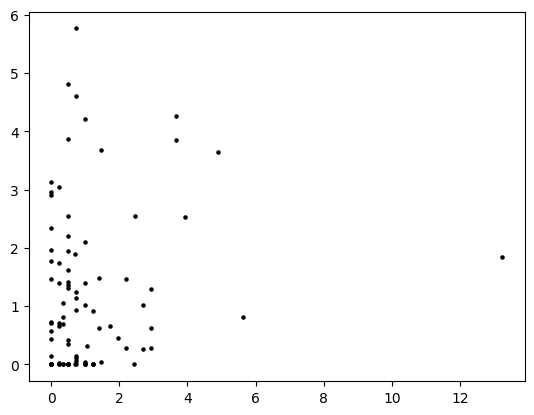

In [257]:
import matplotlib.pyplot as plt

plt.scatter(real, predicted, s=5, c='k')